# Feature space: non-ML

What kind of features are most predictive of mutational stability?

In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import numpy as np
import os
import corner
import sys
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info
from src.utils.data.data_format_tools.common import load_json_as_dict
from src.utils.common.setup_new import prepare_config
from src.utils.circuit.agnostic_circuits.circuit_manager_new import CircuitModeller
from src.utils.evolution.evolver import Evolver
from src.utils.misc.numerical import count_monotonic_group_lengths
from src.utils.misc.string_handling import string_to_tuple_list
from src.utils.misc.type_handling import flatten_listlike, get_first_elements
from src.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from tests_local.shared import create_test_inputs, CONFIG, TEST_CONFIG, five_circuits, mutate, simulate

# config = load_json_as_dict('../tests_local/configs/simple_circuit.json')
SEQ_LENGTH = 20
config = deepcopy(CONFIG)


In [71]:
fn = '../data/ensemble_mutation_effect_analysis/2023_04_04_115620/summarise_simulation/tabulated_mutation_info.csv'
info = pd.read_csv(fn)

In [72]:
# circuits, config, result_writer, info = create_test_inputs(deepcopy(CONFIG))

# circuits, config, data_writer = five_circuits(config, data_writer=None)

In [73]:

# circuits, config, data_writer = mutate(circuits, config, data_writer)

In [74]:

# circuits, config, data_writer = simulate(circuits, config, data_writer)

In [75]:


# info = b_tabulate_mutation_info(data_writer.ensemble_write_dir,
#                                 data_writer=data_writer, experiment_config=config)

In [76]:
# circuits = [Evolver(data_writer=result_writer,
#                     sequence_type=config.get('system_type')).mutate(
#             c,
#             write_to_subsystem=True,
#             algorithm=config.get('mutations', {}).get('algorithm', 'random')) for c in circuits]
# circuit_modeller = CircuitModeller(result_writer=result_writer, config=config)
# circuits = circuit_modeller.batch_circuits(
#     circuits=circuits,
#     methods={
#         "compute_interactions": {},
#         "init_circuits": {'batch': True},
#         'simulate_signal_batch': {'ref_circuit': None,
#                                   'batch': config['simulation']['use_batch_mutations']},
#         'write_results': {'no_visualisations': False, # config['experiment']['no_visualisations'],
#                           'no_numerical': False} #config['experiment']['no_numerical']}
#     }
# )



In [77]:
# circuits[1].interactions.__dict__

## Process summary

In [78]:
num_group_cols = [e.replace('energies', 'binding_sites_groups') for e in get_true_interaction_cols(info, 'energies')]
num_bs_cols = [e.replace('energies', 'binding_sites_count') for e in get_true_interaction_cols(info, 'energies')]


In [79]:
for b, g, bs in zip(get_true_interaction_cols(info, 'binding_sites'), num_group_cols, num_bs_cols):
    fbs = [string_to_tuple_list(bb) for bb in info[b]]
    first = get_first_elements(fbs, empty_replacement=[])
    info[bs] = [count_monotonic_group_lengths(bb) for bb in first]
    info[g] = info[bs].apply(len)


In [80]:
good_cols = list(info.columns)
[good_cols.remove(x) for x in get_true_interaction_cols(info, 'binding_rates_dissociation') + get_true_interaction_cols(info, 'eqconstants') +
 get_true_interaction_cols(info, 'energies') + get_true_interaction_cols(info, 'binding_sites') + num_group_cols + num_bs_cols]
good_cols


['circuit_name',
 'mutation_name',
 'mutation_num',
 'mutation_type',
 'mutation_positions',
 'path_to_template_circuit',
 'name',
 'interacting',
 'self_interacting',
 'num_interacting',
 'num_self_interacting',
 'num_interacting_diff_to_base_circuit',
 'num_self_interacting_diff_to_base_circuit',
 'num_interacting_ratio_from_mutation_to_base',
 'num_self_interacting_ratio_from_mutation_to_base',
 'fold_change',
 'final_deriv',
 'initial_steady_states',
 'max_amount',
 'min_amount',
 'overshoot',
 'RMSE',
 'steady_states',
 'response_time_wrt_species-6',
 'response_time_wrt_species-6_diff_to_base_circuit',
 'response_time_wrt_species-6_ratio_from_mutation_to_base',
 'precision_wrt_species-6',
 'precision_wrt_species-6_diff_to_base_circuit',
 'precision_wrt_species-6_ratio_from_mutation_to_base',
 'sensitivity_wrt_species-6',
 'sensitivity_wrt_species-6_diff_to_base_circuit',
 'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
 'fold_change_diff_to_base_circuit',
 'final_deriv_di

In [81]:
binding_idx_map = {e.replace('energies_', ''): i for i, e in enumerate(get_true_interaction_cols(info, 'energies'))}

In [82]:
infom = info.melt(good_cols, value_vars=get_true_interaction_cols(info, 'energies'), var_name='energies_idx', value_name='energies')
dfm = info.melt(good_cols, value_vars=num_group_cols, var_name='num_groups_idx', value_name='num_groups')
infom['idx_species_binding'] = dfm['num_groups_idx'].apply(lambda x: binding_idx_map[x.replace('binding_sites_groups_', '')])
infom['num_groups'] = dfm['num_groups']
dfm = info.melt(good_cols, value_vars=num_bs_cols, var_name='num_bs_idx', value_name='num_bs')
infom['num_bs'] = dfm['num_bs']

for k in ['binding_sites', 'binding_rates_dissociation', 'eqconstants']:
    dfm = info.melt(good_cols, value_vars=get_true_interaction_cols(info, k), var_name=f'{k}_idx', value_name=k)
    infom[k] = dfm[k]


## Visualisations

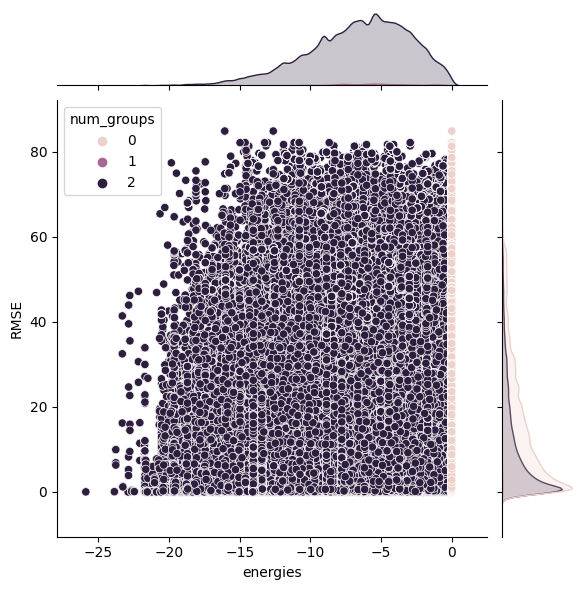

In [83]:
sns.jointplot(infom, x='energies', y='RMSE', hue='num_groups')

<AxesSubplot: xlabel='energies', ylabel='RMSE'>

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


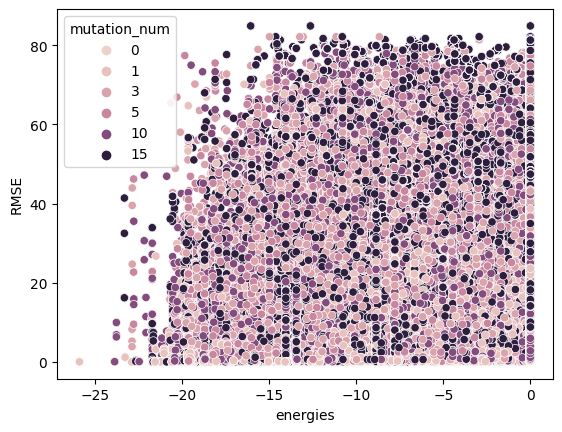

In [84]:
sns.scatterplot(infom, x='energies', y='RMSE', hue='mutation_num')

In [85]:
infom.columns

Index(['circuit_name', 'mutation_name', 'mutation_num', 'mutation_type',
       'mutation_positions', 'path_to_template_circuit', 'name', 'interacting',
       'self_interacting', 'num_interacting', 'num_self_interacting',
       'num_interacting_diff_to_base_circuit',
       'num_self_interacting_diff_to_base_circuit',
       'num_interacting_ratio_from_mutation_to_base',
       'num_self_interacting_ratio_from_mutation_to_base', 'fold_change',
       'final_deriv', 'initial_steady_states', 'max_amount', 'min_amount',
       'overshoot', 'RMSE', 'steady_states', 'response_time_wrt_species-6',
       'response_time_wrt_species-6_diff_to_base_circuit',
       'response_time_wrt_species-6_ratio_from_mutation_to_base',
       'precision_wrt_species-6',
       'precision_wrt_species-6_diff_to_base_circuit',
       'precision_wrt_species-6_ratio_from_mutation_to_base',
       'sensitivity_wrt_species-6',
       'sensitivity_wrt_species-6_diff_to_base_circuit',
       'sensitivity_wrt_specie

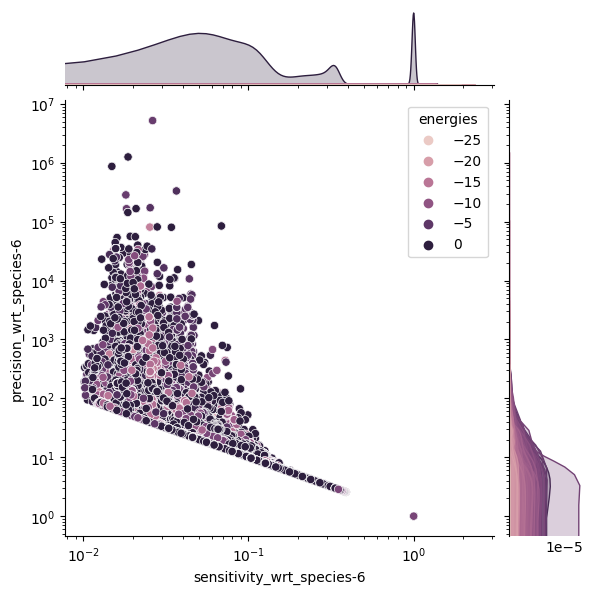

In [86]:
sns.jointplot(infom, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='energies')
plt.xscale('log')
plt.yscale('log')

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


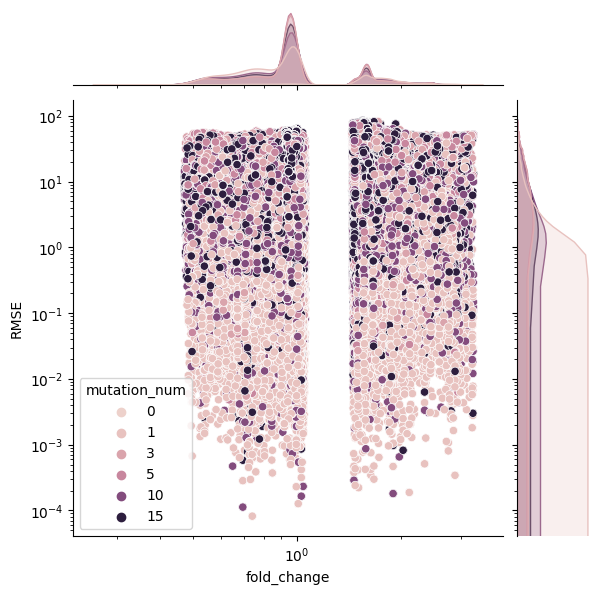

In [87]:
sns.jointplot(infom, x='fold_change', y='RMSE', hue='mutation_num')
plt.xscale('log')
plt.yscale('log')

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


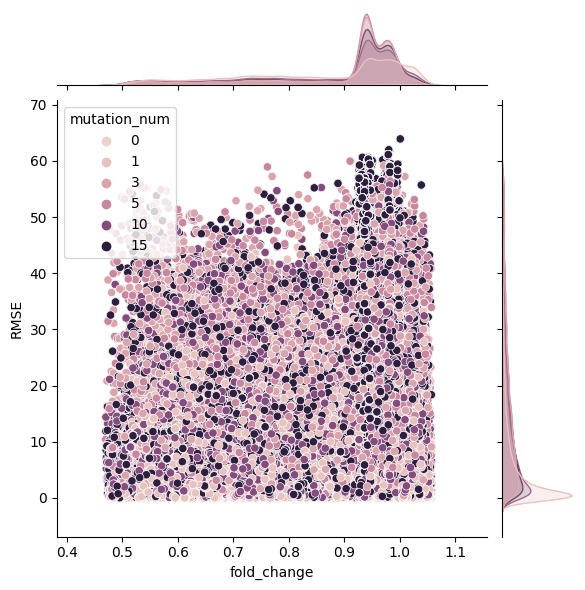

In [88]:
sns.jointplot(infom[infom['sample_name'] != 'RNA_0'], x='fold_change', y='RMSE', hue='mutation_num')
# plt.xscale('log')
# plt.yscale('log')

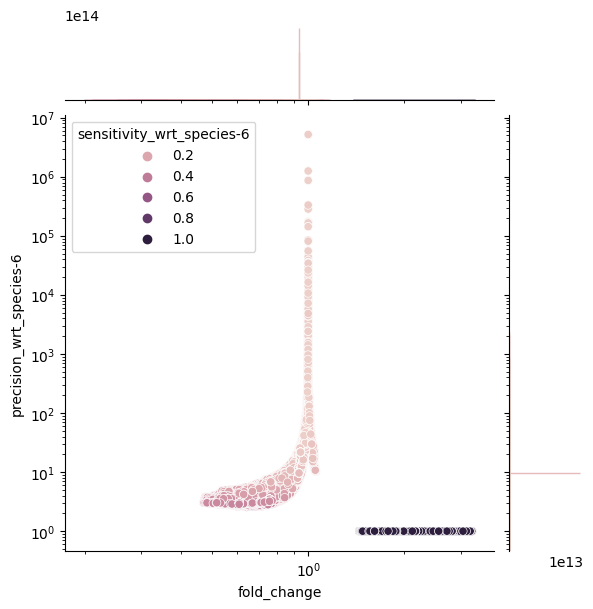

In [89]:
# sns.jointplot(infom, x='fold_change', y='precision_wrt_species-6', hue='sensitivity_wrt_species-6')
# plt.xscale('log')
# plt.yscale('log')

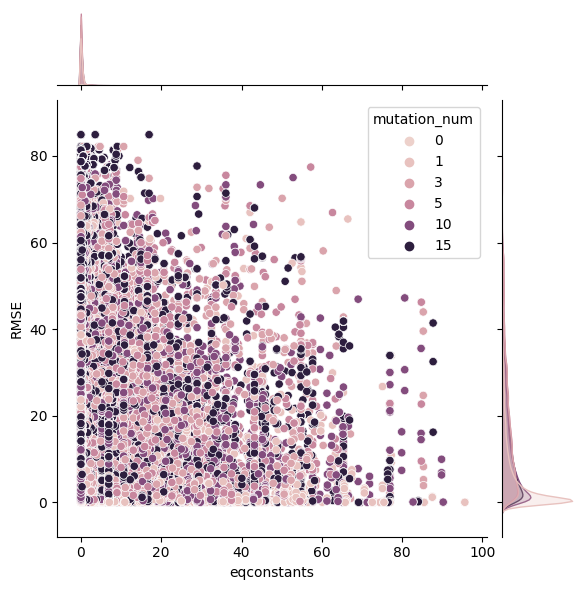

In [90]:
sns.jointplot(infom, x='eqconstants', y='RMSE', hue='mutation_num')

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


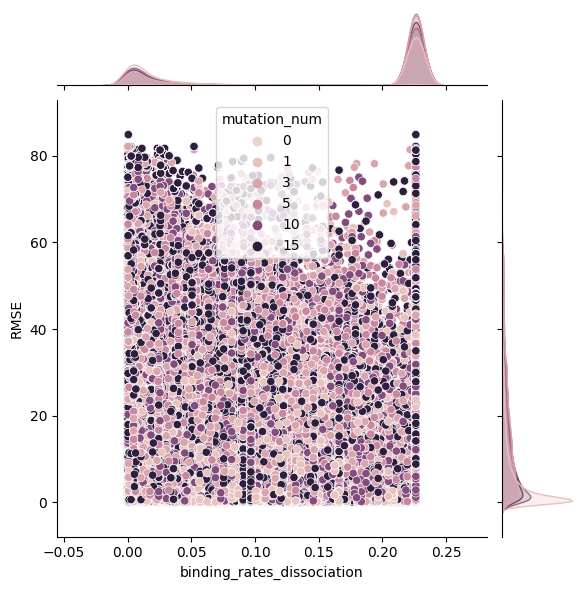

In [91]:
sns.jointplot(infom, x='binding_rates_dissociation', y='RMSE', hue='mutation_num')

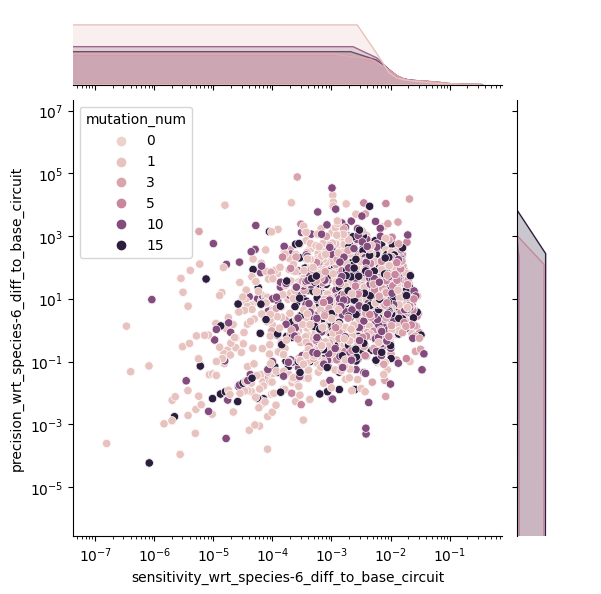

In [92]:
sns.jointplot(infom, x='sensitivity_wrt_species-6_diff_to_base_circuit', y='precision_wrt_species-6_diff_to_base_circuit', hue='mutation_num')
plt.xscale('log')
plt.yscale('log')

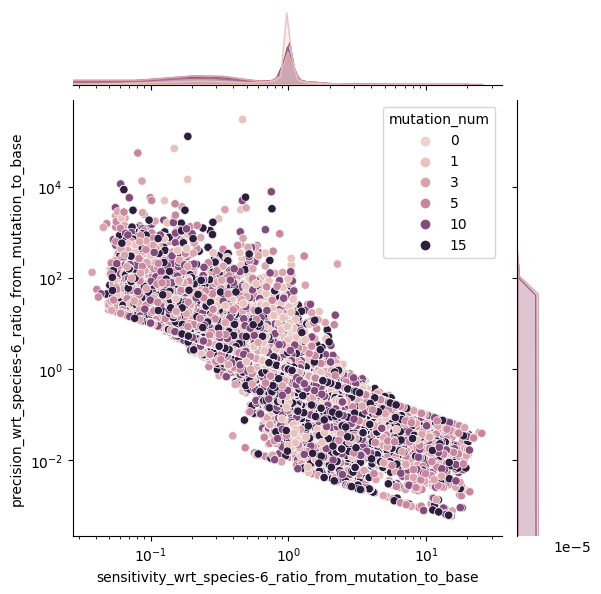

In [93]:
sns.jointplot(infom, x='sensitivity_wrt_species-6_ratio_from_mutation_to_base', y='precision_wrt_species-6_ratio_from_mutation_to_base', hue='mutation_num')
plt.xscale('log')
plt.yscale('log')

In [94]:
# sns.scatterplot(infom[infom['mutation_name'] == 'ref_circuit'], x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='energies')
# plt.xscale('log')
# plt.yscale('log')

In [95]:
# sns.jointplot(infom, x='sensitivity_wrt_species-6_diff_to_base_circuit', y='precision_wrt_species-6_diff_to_base_circuit', hue='mutation_num')
# plt.yscale('log')

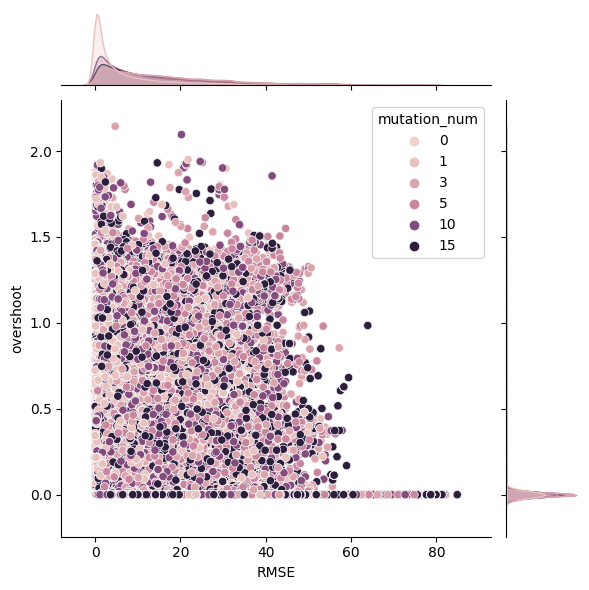

In [112]:
sns.jointplot(infom, x='RMSE', y='overshoot', hue='mutation_num')
# plt.yscale('log')

/tmp/ipykernel_2115386/1342685528.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(infom, x='fold_change', y='sensitivity_wrt_species-6_diff_to_base_circuit', shade=True) #, hue='mutation_num')


<AxesSubplot: xlabel='fold_change', ylabel='sensitivity_wrt_species-6_diff_to_base_circuit'>

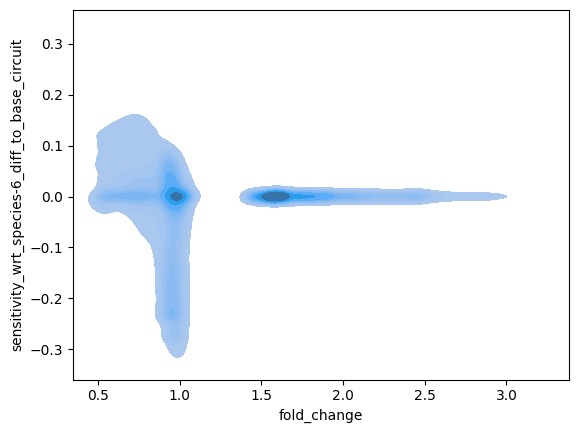

: 

In [144]:
sns.scatterplot(infom, x='fold_change', y='sensitivity_wrt_species-6_diff_to_base_circuit') #, hue='mutation_num')
sns.kdeplot(infom, x='fold_change', y='sensitivity_wrt_species-6_diff_to_base_circuit') #, fill=True, cbar=True) #, hue='mutation_num')
# plt.yscale('log')

Relevant columns 

In [96]:
relevant_cols = [
    'fold_change', 
    # 'initial_steady_states', 
    # 'max_amount', 'min_amount',
    'overshoot', 
    'RMSE', 
    'steady_states', 
    # 'response_time_wrt_species-6',
    # 'response_time_wrt_species-6_diff_to_base_circuit',
    # 'response_time_wrt_species-6_ratio_from_mutation_to_base',
    'precision_wrt_species-6',
    'precision_wrt_species-6_diff_to_base_circuit',
    'precision_wrt_species-6_ratio_from_mutation_to_base',
    'sensitivity_wrt_species-6',
    'sensitivity_wrt_species-6_diff_to_base_circuit',
    'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
    'fold_change_diff_to_base_circuit',
    # 'initial_steady_states_diff_to_base_circuit',
    # 'max_amount_diff_to_base_circuit', 'min_amount_diff_to_base_circuit',
    'overshoot_diff_to_base_circuit', 
    # 'RMSE_diff_to_base_circuit',
    'steady_states_diff_to_base_circuit',
    'fold_change_ratio_from_mutation_to_base',
    # 'initial_steady_states_ratio_from_mutation_to_base',
    # 'max_amount_ratio_from_mutation_to_base',
    # 'min_amount_ratio_from_mutation_to_base',
    # 'overshoot_ratio_from_mutation_to_base',
    # 'RMSE_ratio_from_mutation_to_base',
    'steady_states_ratio_from_mutation_to_base', 
    'energies', 
    # 'num_groups',
    'binding_rates_dissociation',
    'eqconstants'
    ]
info_summ = infom.groupby(['circuit_name', 'mutation_num'], as_index=False).agg(
    {c: ['std', 'mean'] for c in relevant_cols})

    


<AxesSubplot: xlabel='RMSE', ylabel='Count'>

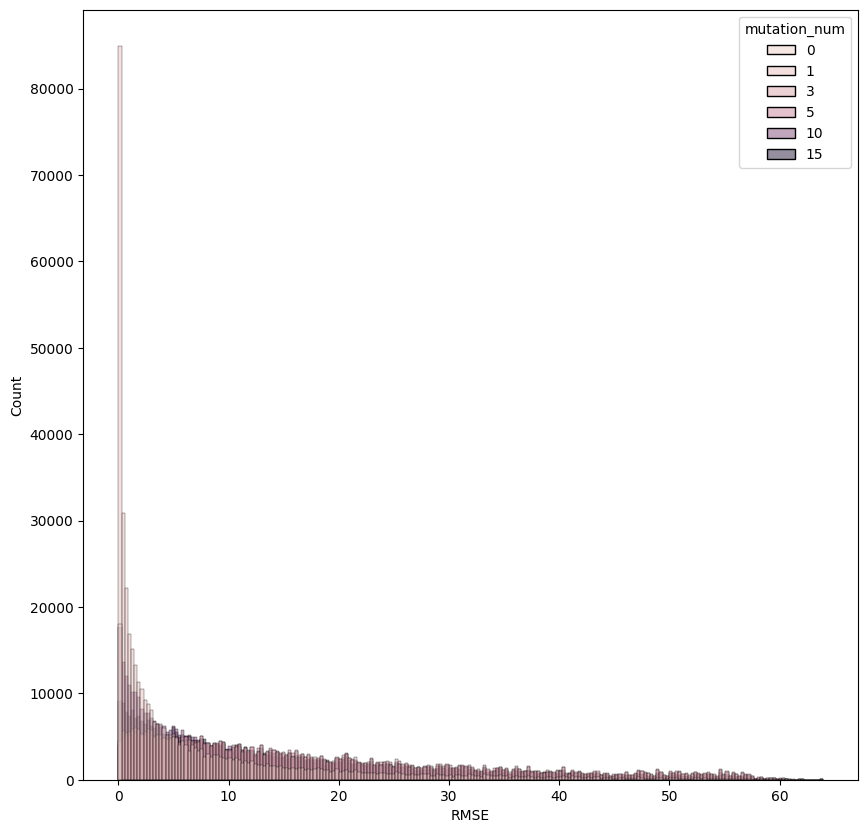

In [97]:
plt.figure(figsize=(10,10))
sns.histplot(infom[infom['sample_name'] != 'RNA_0'], x='RMSE', hue='mutation_num')


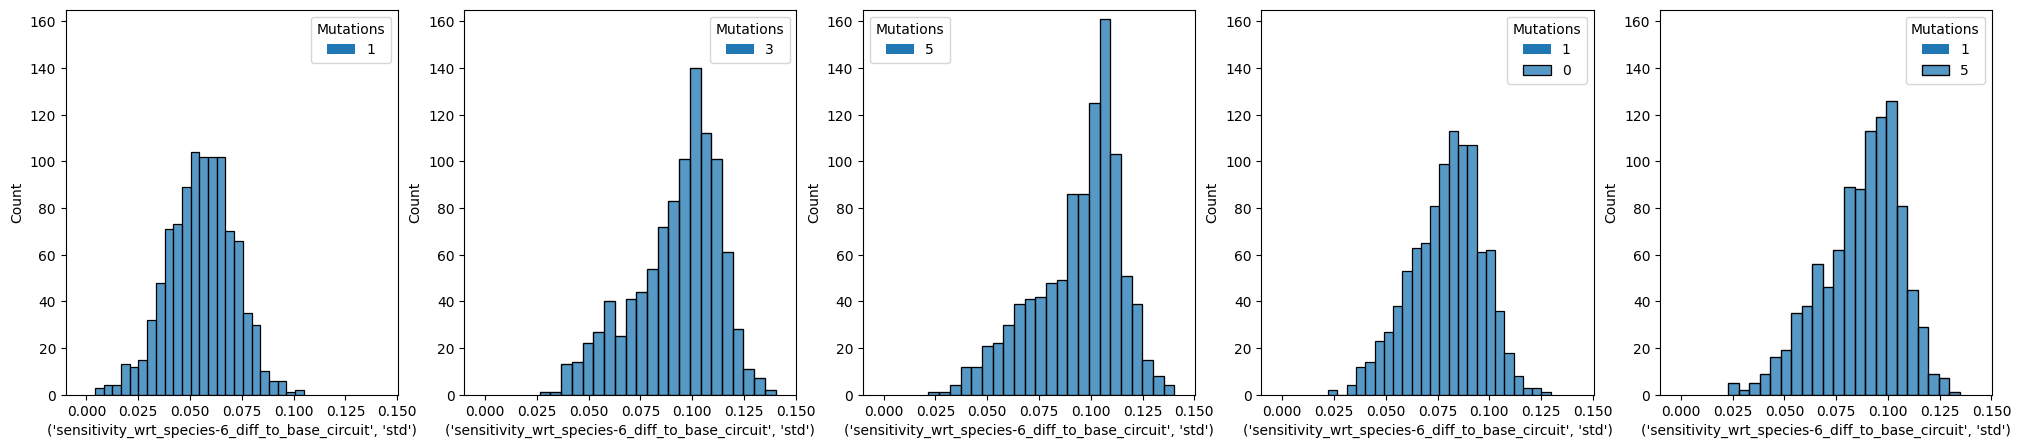

In [98]:
plt.figure(figsize=(5*len(info_summ['mutation_num'].unique()), 5))
for i, m in enumerate(info_summ['mutation_num'].unique()):
    if m != 0:
        ax = plt.subplot(1, len(info_summ['mutation_num'].unique()), i)
        sns.histplot(info_summ[info_summ['mutation_num'] == m], x=('sensitivity_wrt_species-6_diff_to_base_circuit', 'std'))
        plt.legend(str(m), title='Mutations')
        plt.xlim([info_summ[('sensitivity_wrt_species-6_diff_to_base_circuit', 'std')].min() - 0.01, info_summ[('sensitivity_wrt_species-6_diff_to_base_circuit', 'std')].max() + 0.01])
        plt.ylim([0,165])


<AxesSubplot: xlabel="('sensitivity_wrt_species-6_diff_to_base_circuit', 'std')", ylabel='Count'>

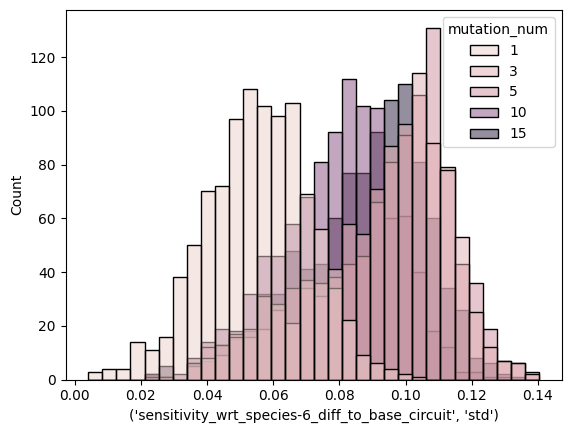

In [99]:
sns.histplot(info_summ[info_summ['mutation_num'] != 0], x=('sensitivity_wrt_species-6_diff_to_base_circuit', 'std'), hue='mutation_num')


## Check out correlations

In [100]:
infom[relevant_cols + ['mutation_num']].corr()

fold_change  overshoot  \
fold_change                                            1.000000  -0.096068   
overshoot                                             -0.096068   1.000000   
RMSE                                                   0.050495  -0.094256   
steady_states                                          0.594831  -0.067309   
precision_wrt_species-6                               -0.002459   0.017408   
precision_wrt_species-6_diff_to_base_circuit          -0.000918   0.015044   
precision_wrt_species-6_ratio_from_mutation_to_...    -0.003086   0.021482   
sensitivity_wrt_species-6                              0.827036  -0.243310   
sensitivity_wrt_species-6_diff_to_base_circuit         0.067185  -0.053531   
sensitivity_wrt_species-6_ratio_from_mutation_t...    -0.084468  -0.060360   
fold_change_diff_to_base_circuit                      -0.136750   0.069680   
overshoot_diff_to_base_circuit                         0.119284   0.257954   
steady_states_diff_to_base_circuit                     0.016852  -0.039865   
fold_change_ratio_from_mutation_to_base               -0.105722   0.052055   
steady_states_ratio_from_mutation_to_base             -0.085909  -0.028491   
energies                                              -0.012070  -0.097887   
binding_rates_dissociation                            -0.007413  -0.087686   
eqconstants                                            0.004859   0.037497   
mutation_num                                          -0.002328  -0.030839   

                                                        RMSE  steady_states  \
fold_change                                         0.050495       0.594831   
overshoot                                          -0.094256      -0.067309   
RMSE                                                1.000000       0.336566   
steady_states                                       0.336566       1.000000   
precision_wrt_species-6                            -0.001305      -0.001255   
precision_wrt_species-6_diff_to_base_circuit       -0.000697      -0.000317   
precision_wrt_species-6_ratio_from_mutation_to_...  0.001464      -0.001263   
sensitivity_wrt_species-6                           0.010942       0.566275   
sensitivity_wrt_species-6_diff_to_base_circuit     -0.316610      -0.035948   
sensitivity_wrt_species-6_ratio_from_mutation_t... -0.089681      -0.079168   
fold_change_diff_to_base_circuit                   -0.075113      -0.209415   
overshoot_diff_to_base_circuit                     -0.027483       0.034100   
steady_states_diff_to_base_circuit                  0.611284       0.420010   
fold_change_ratio_from_mutation_to_base             0.185979      -0.078905   
steady_states_ratio_from_mutation_to_base           0.683137       0.193243   
energies                                            0.122853       0.139777   
binding_rates_dissociation                          0.139069       0.135337   
eqconstants                                        -0.032882      -0.044892   
mutation_num                                        0.087282       0.021431   

                                                    precision_wrt_species-6  \
fold_change                                                       -0.002459   
overshoot                                                          0.017408   
RMSE                                                              -0.001305   
steady_states                                                     -0.001255   
precision_wrt_species-6                                            1.000000   
precision_wrt_species-6_diff_to_base_circuit                       0.999752   
precision_wrt_species-6_ratio_from_mutation_to_...                 0.968205   
sensitivity_wrt_species-6                                         -0.005930   
sensitivity_wrt_species-6_diff_to_base_circuit                    -0.003318   
sensitivity_wrt_species-6_ratio_from_mutation_t...                -0.003958   
fold_change_diff_to_base_circuit         

In [101]:
infom[infom['sample_name'] != 'RNA_0'][relevant_cols + ['mutation_num']].corr()['mutation_num'].sort_values()

overshoot                                               -0.038462
sensitivity_wrt_species-6_diff_to_base_circuit          -0.028947
sensitivity_wrt_species-6                               -0.027774
overshoot_diff_to_base_circuit                          -0.027662
eqconstants                                             -0.003962
precision_wrt_species-6                                 -0.002128
precision_wrt_species-6_diff_to_base_circuit            -0.002128
precision_wrt_species-6_ratio_from_mutation_to_base     -0.001370
sensitivity_wrt_species-6_ratio_from_mutation_to_base    0.007494
fold_change                                              0.023426
fold_change_diff_to_base_circuit                         0.024350
energies                                                 0.025348
fold_change_ratio_from_mutation_to_base                  0.028379
steady_states                                            0.031816
binding_rates_dissociation                               0.031835
steady_sta

<AxesSubplot: xlabel='sensitivity_wrt_species-6_diff_to_base_circuit', ylabel='Count'>

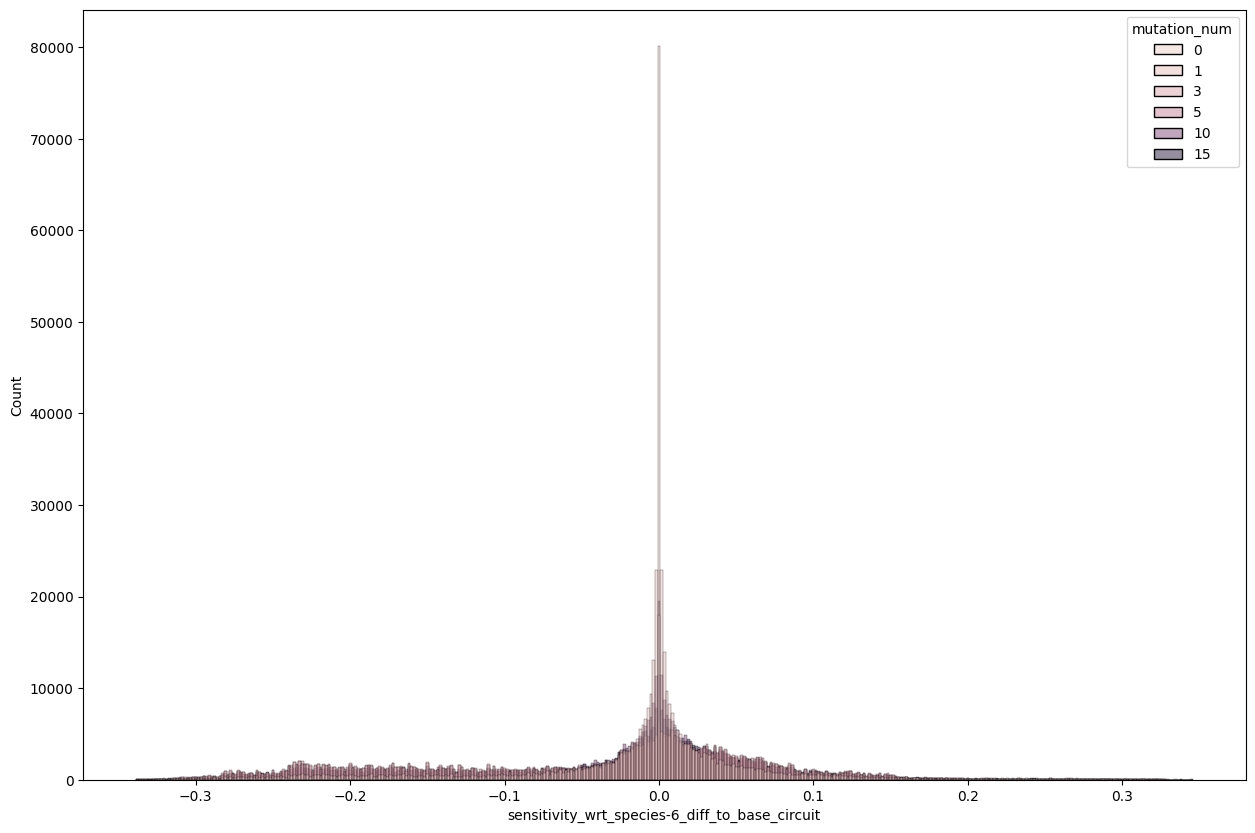

In [102]:
plt.figure(figsize=(15,10))
sns.histplot(infom[infom['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6_diff_to_base_circuit', hue='mutation_num')


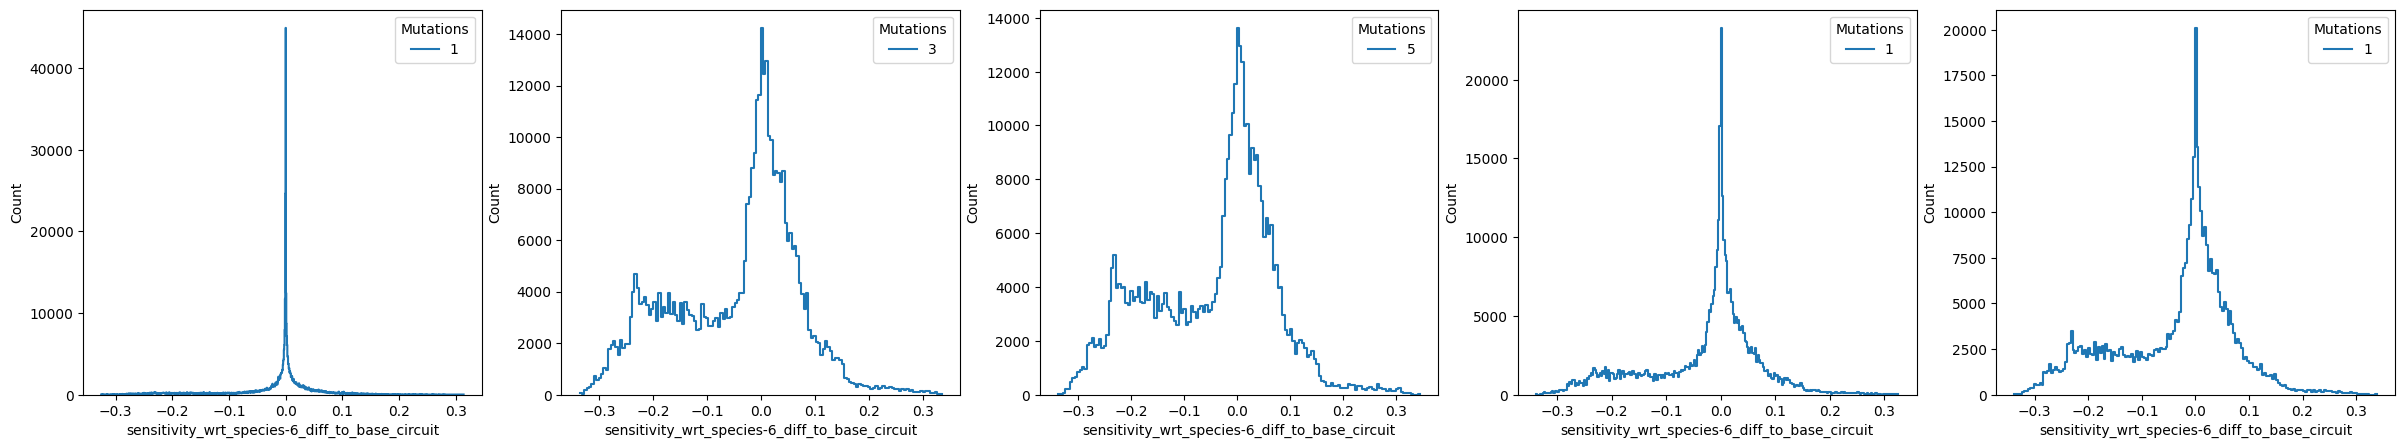

In [103]:
plt.figure(figsize=(6*len(info_summ['mutation_num'].unique()), 5))
for i, m in enumerate(info_summ['mutation_num'].unique()):
    if m != 0:
        ax = plt.subplot(1, len(info_summ['mutation_num'].unique()), i)
        sns.histplot(infom[(infom['sample_name'] != 'RNA_0') & (infom['mutation_num'] == m)], x='sensitivity_wrt_species-6_diff_to_base_circuit', stat='count', element='step', fill=False)
        plt.legend(str(m), title='Mutations')
        # plt.xlim([info_summ[('sensitivity_wrt_species-6_diff_to_base_circuit', 'std')].min() - 0.01, info_summ[('sensitivity_wrt_species-6_diff_to_base_circuit', 'std')].max() + 0.01])
        # plt.ylim([0,165])


<AxesSubplot: xlabel='binding_rates_dissociation', ylabel='Count'>

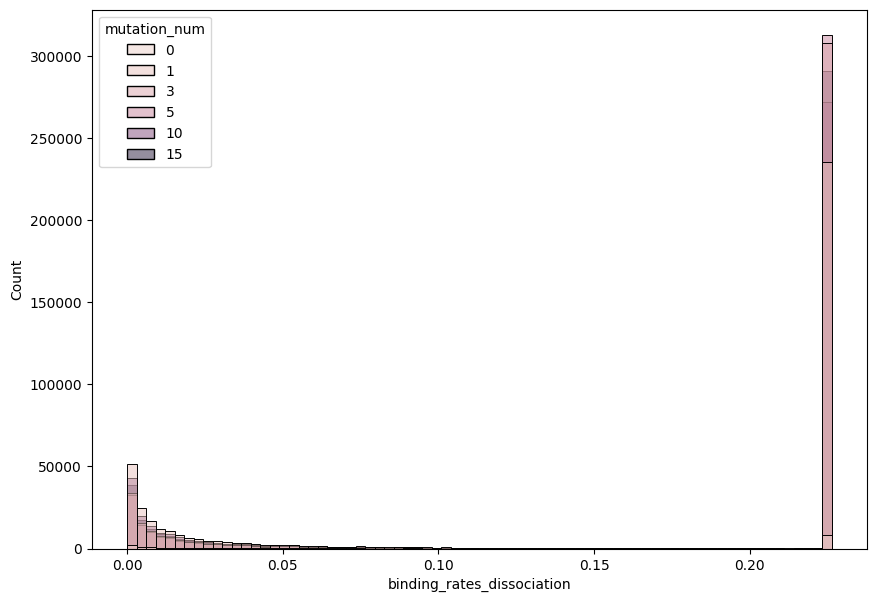

In [104]:
plt.figure(figsize=(10,7))
sns.histplot(infom[infom['sample_name'] != 'RNA_0'], x='binding_rates_dissociation', hue='mutation_num')


<AxesSubplot: xlabel='eqconstants', ylabel='Count'>

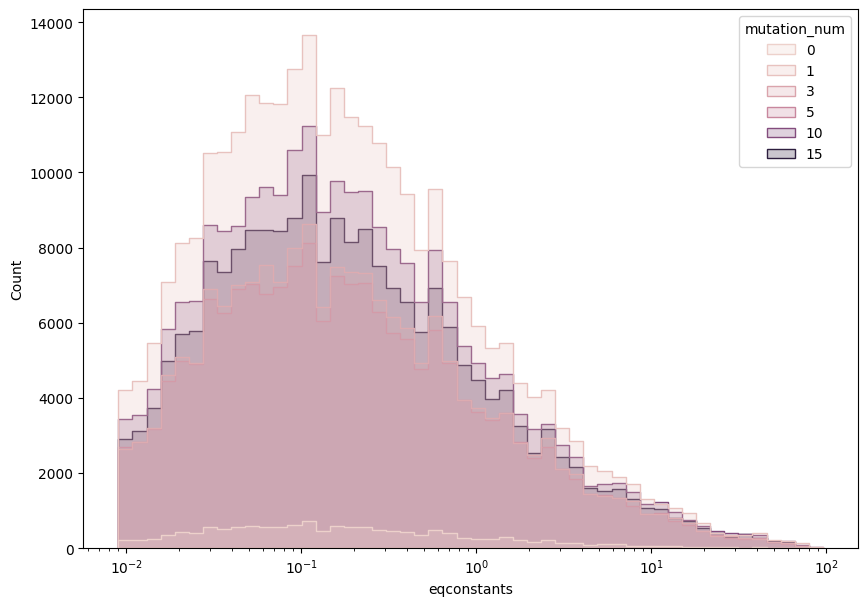

In [143]:
plt.figure(figsize=(10,7))
sns.histplot(infom[infom['eqconstants'] > 0.009], x='eqconstants', hue = 'mutation_num', multiple='layer', element='step', stat='count', log_scale=[True, False], bins=50)
# plt.xscale('log')


In [127]:
infom['eqconstants'].mode()

0    0.00667
Name: eqconstants, dtype: float64

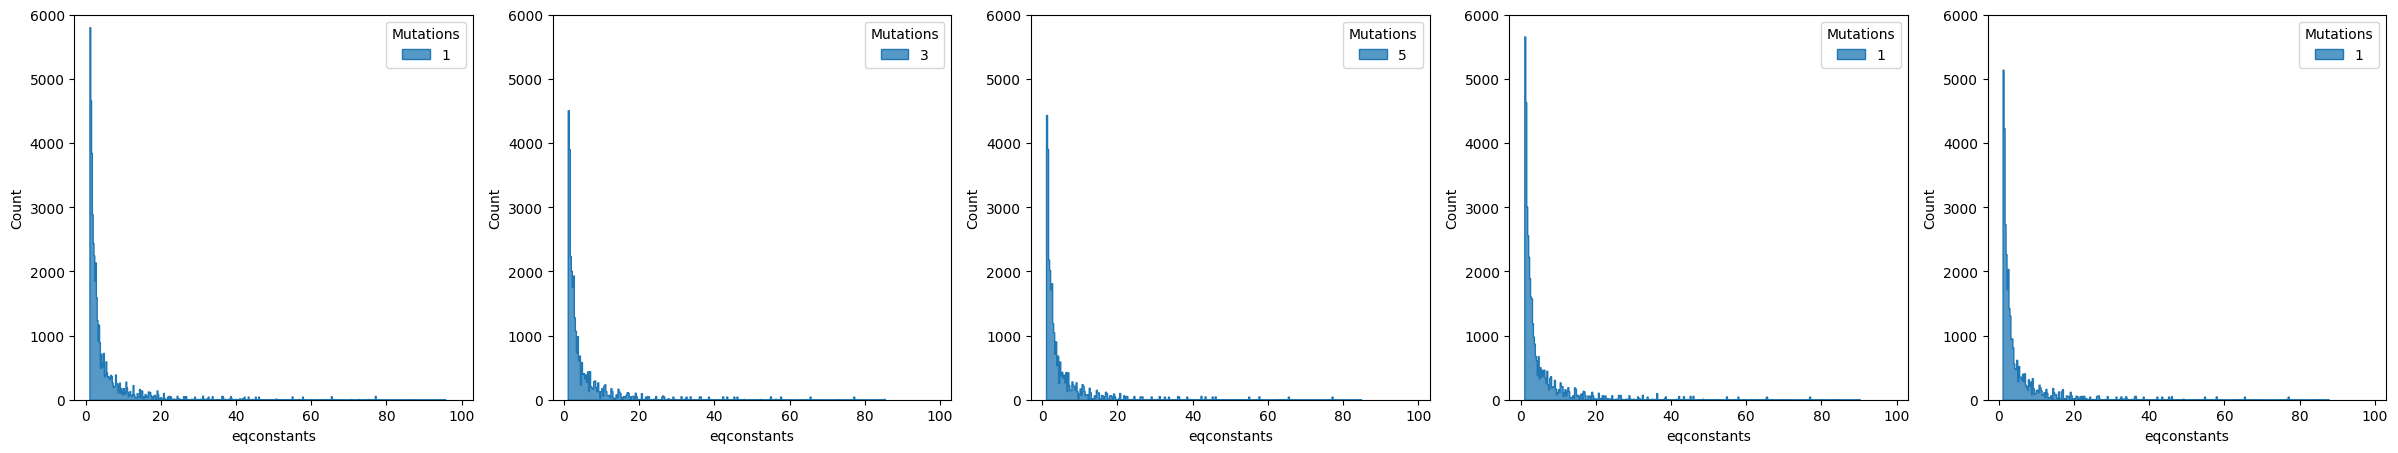

In [122]:
plt.figure(figsize=(6*len(info_summ['mutation_num'].unique()), 5))
for i, m in enumerate(info_summ['mutation_num'].unique()):
    if m != 0:
        ax = plt.subplot(1, len(info_summ['mutation_num'].unique()), i)
        sns.histplot(infom[(infom['eqconstants'] >= 1) & (infom['mutation_num'] == m)], x='eqconstants', stat='count', element='step', fill=True)
        plt.legend(str(m), title='Mutations')
        plt.xlim([-3, 103])
        plt.ylim([0,6000])


<AxesSubplot: xlabel='energies', ylabel='Count'>

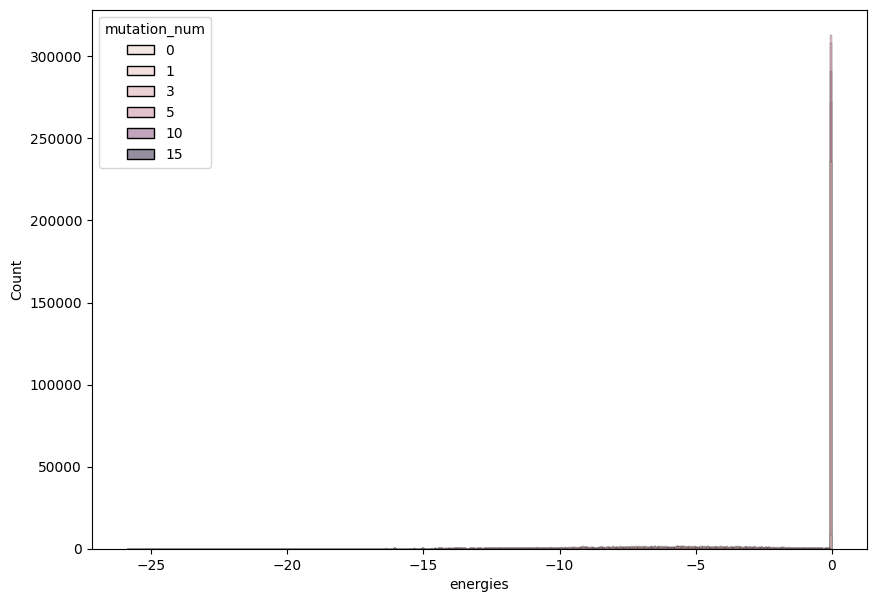

In [114]:
plt.figure(figsize=(10,7))
sns.histplot(infom[infom['sample_name'] != 'RNA_0'], x='energies', hue='mutation_num')


In [105]:
len(relevant_cols)

18

core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593: Too few points to create valid contours WARNING
core.py:hist2d():593

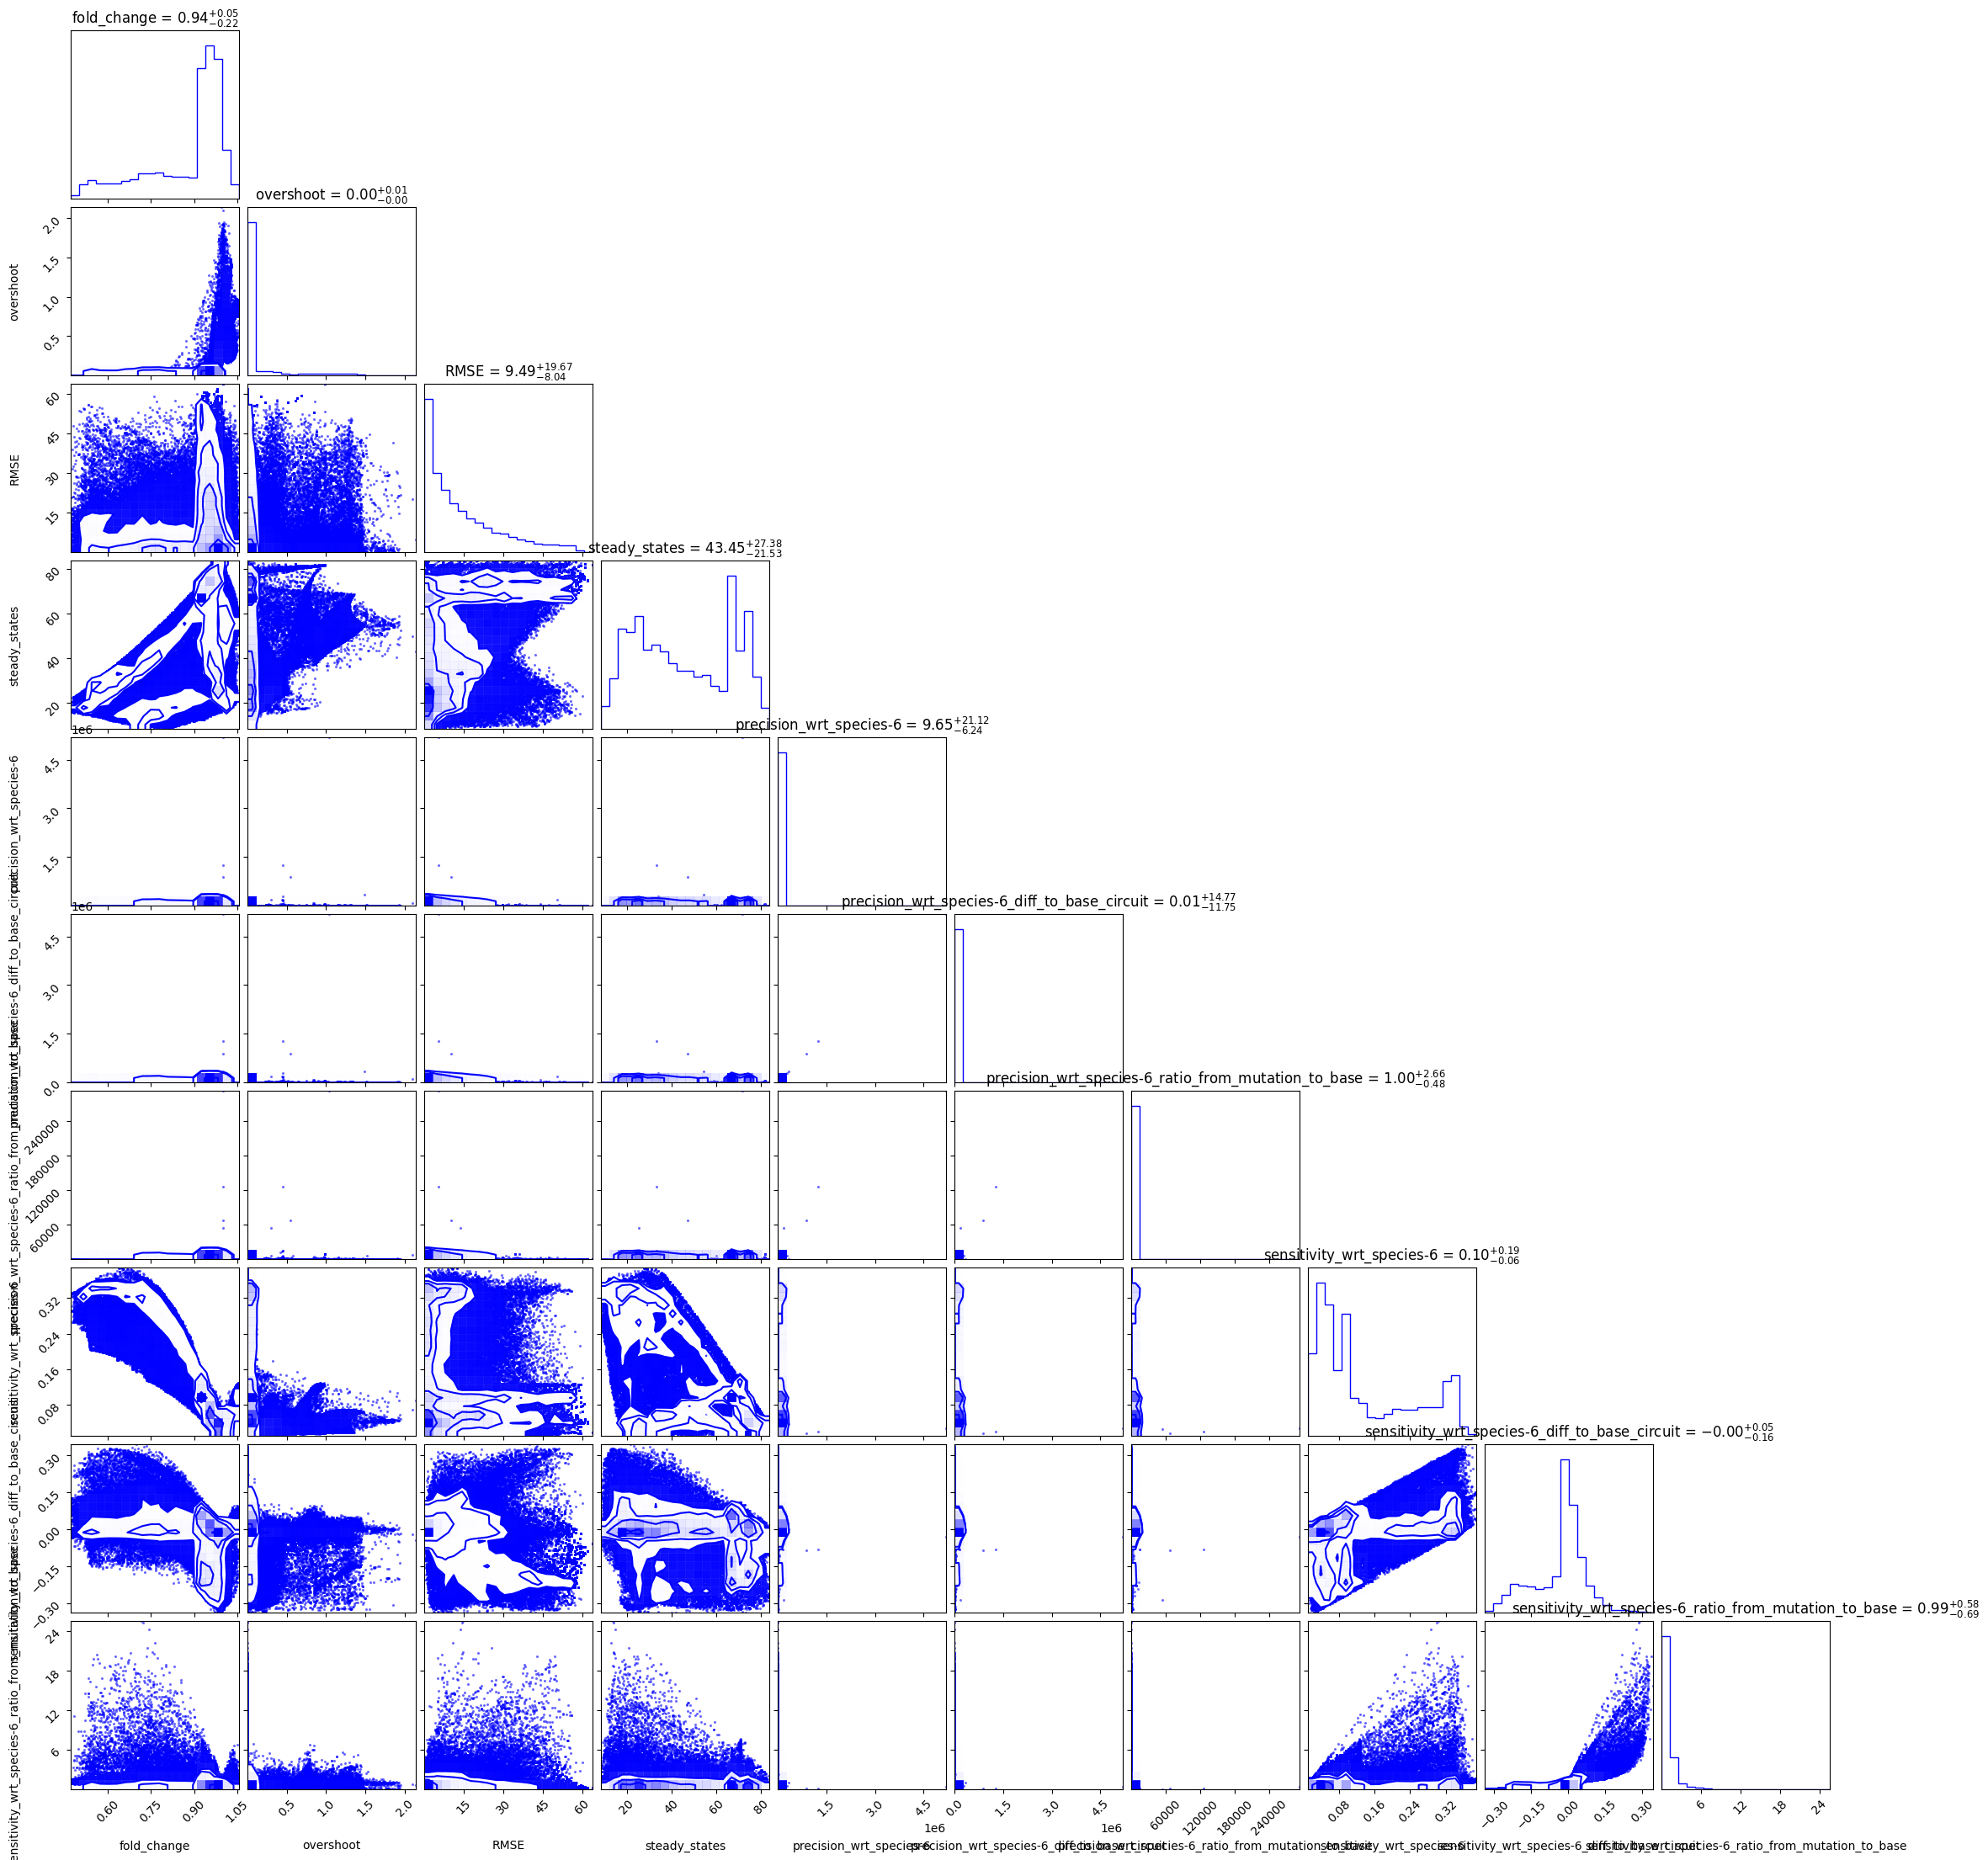

In [106]:
fig = corner.corner(infom[infom['sample_name'] != 'RNA_0'][relevant_cols[0:10]], labels=relevant_cols[0:10], show_titles=True, title_kwargs={"fontsize": 12}, color='b')

In [107]:
infom[relevant_cols][(infom[relevant_cols] < np.inf) & (infom[relevant_cols] != np.nan) & (np.isnan(infom[relevant_cols]) == False)]

fold_change  overshoot       RMSE  steady_states  \
0           1.867110   0.000000   0.000000      97.915180   
1           1.014282   1.133488   0.000000      60.183170   
2           0.717795   0.000000   0.000000      16.986261   
3           1.867646   0.000000   0.023113      97.892430   
4           1.014296   1.134190   0.017068      60.201187   
...              ...        ...        ...            ...   
3266995     0.609217   0.000000   8.813139      24.353807   
3266996     0.946410   0.000000  14.157517      75.251205   
3266997     2.117699   0.000000   3.602549      93.910150   
3266998     0.608303   0.000000   6.458021      22.542273   
3266999     0.998620   0.375473  34.259808      28.173351   

         precision_wrt_species-6  \
0                       1.000000   
1                      60.712547   
2                       3.072623   
3                       1.000000   
4                      60.691450   
...                          ...   
3266995                 2.986736   
3266996                21.779633   
3266997                 1.000000   
3266998                 2.853481   
3266999               810.128360   

         precision_wrt_species-6_diff_to_base_circuit  \
0                                            0.000000   
1                                            0.000000   
2                                            0.000000   
3                                            0.000000   
4                                           -0.021099   
...                                               ...   
3266995                                     -0.050504   
3266996                                   -134.109180   
3266997                                      0.000000   
3266998                                     -0.183759   
3266999                                    654.239560   

         precision_wrt_species-6_ratio_from_mutation_to_base  \
0                                                 1.000000     
1                                                 1.000000     
2                                                 1.000000     
3                                                 1.000000     
4                                                 0.999653     
...                                                    ...     
3266995                                           0.983372     
3266996                                           0.139713     
3266997                                           1.000000     
3266998                                           0.939498     
3266999                                           5.196835     

         sensitivity_wrt_species-6  \
0                         1.000000   
1                         0.038502   
2                         0.325455   
3                         1.000000   
4                         0.038501   
...                            ...   
3266995                   0.334814   
3266996                   0.045914   
3266997                   1.000000   
3266998                   0.350449   
3266999                   0.013142   

         sensitivity_wrt_species-6_diff_to_base_circuit  \
0                                          0.000000e+00   
1                                          0.000000e+00   
2                                          0.000000e+00   
3                                          0.000000e+00   
4                                         -5.252659e-07   
...                                                 ...   
3266995                                    5.567402e-03   
3266996                                    1.936852e-02   
3266997                                    0.000000e+00   
3266998                                    2.120286e-02   
3266999                                   -1.340420e-02   

         sensitivity_wrt_species-6_ratio_from_mutation_to_base  \
0                                                 1.000000       
1                                                 1.000000       
2                        

In [108]:
fig.savefig('test.png')

In [109]:
for r in relevant_cols:
    if any([type(i) == str for i in infom[r]]):
        print(r)

end

In [110]:
infom[relevant_cols]

fold_change  overshoot       RMSE  steady_states  \
0           1.867110   0.000000   0.000000      97.915180   
1           1.014282   1.133488   0.000000      60.183170   
2           0.717795   0.000000   0.000000      16.986261   
3           1.867646   0.000000   0.023113      97.892430   
4           1.014296   1.134190   0.017068      60.201187   
...              ...        ...        ...            ...   
3266995     0.609217   0.000000   8.813139      24.353807   
3266996     0.946410   0.000000  14.157517      75.251205   
3266997     2.117699   0.000000   3.602549      93.910150   
3266998     0.608303   0.000000   6.458021      22.542273   
3266999     0.998620   0.375473  34.259808      28.173351   

         precision_wrt_species-6  \
0                       1.000000   
1                      60.712547   
2                       3.072623   
3                       1.000000   
4                      60.691450   
...                          ...   
3266995                 2.986736   
3266996                21.779633   
3266997                 1.000000   
3266998                 2.853481   
3266999               810.128360   

         precision_wrt_species-6_diff_to_base_circuit  \
0                                            0.000000   
1                                            0.000000   
2                                            0.000000   
3                                            0.000000   
4                                           -0.021099   
...                                               ...   
3266995                                     -0.050504   
3266996                                   -134.109180   
3266997                                      0.000000   
3266998                                     -0.183759   
3266999                                    654.239560   

         precision_wrt_species-6_ratio_from_mutation_to_base  \
0                                                 1.000000     
1                                                 1.000000     
2                                                 1.000000     
3                                                 1.000000     
4                                                 0.999653     
...                                                    ...     
3266995                                           0.983372     
3266996                                           0.139713     
3266997                                           1.000000     
3266998                                           0.939498     
3266999                                           5.196835     

         sensitivity_wrt_species-6  \
0                         1.000000   
1                         0.038502   
2                         0.325455   
3                         1.000000   
4                         0.038501   
...                            ...   
3266995                   0.334814   
3266996                   0.045914   
3266997                   1.000000   
3266998                   0.350449   
3266999                   0.013142   

         sensitivity_wrt_species-6_diff_to_base_circuit  \
0                                          0.000000e+00   
1                                          0.000000e+00   
2                                          0.000000e+00   
3                                          0.000000e+00   
4                                         -5.252659e-07   
...                                                 ...   
3266995                                    5.567402e-03   
3266996                                    1.936852e-02   
3266997                                    0.000000e+00   
3266998                                    2.120286e-02   
3266999                                   -1.340420e-02   

         sensitivity_wrt_species-6_ratio_from_mutation_to_base  \
0                                                 1.000000       
1                                                 1.000000       
2                        